In [4]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# os.chdir('../')
import sys
# print("Current working directory:", os.getcwd())
sys.path.insert(0,'/home/mariia.sidulova/domid_upgraded/DomId')
sys.path.insert(0, '/home/mariia.sidulova/domid_upgraded/DomId/DomainLab')
from domid.arg_parser import mk_parser_main


In [5]:

def get_most_recent_directory(directory):
    try:
        directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
        directories.sort(key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)
        return os.path.join(directory, directories[0])
    except Exception as e:
        print("Error:", e)
        return None



In [6]:
import pickle
def load_files(path):
    df = pd.read_csv(os.path.join(path, 'clustering_results.csv'))
    
    domain = df['predictions'].values
    
    vec_d = df['vec_d_labels'].values
    vec_y = df['vec_y_labels'].values
    img_locs = df['image_id_labels'].values

    Z = np.load(os.path.join(path, "Z_space.npy"))
    model_name = path.split('_')[-1]
    with open(os.path.join(path, 'commandline_arguments.p'), 'rb') as file:
        command_line = pickle.load(file)


    
    return domain, vec_d, vec_y, img_locs, model_name, command_line

In [7]:
def something_per_domain(domain, another_label):
    """
    domain - predicted domain labels 
    another_label - some other label that corresponds to each of the predicted domain (
    assumed that both domain and something have the same img_loc reference order 
    """
    u_something = np.unique(another_label)
    u_domain = np.unique(domain)
    print('unique predicted domain', u_domain)
    print('unique true label', u_something)
    
    array_counters=[]
    for i in u_domain:
        for j in u_something:
            counter = 0
            for idx in range(0, len(domain)):
                if domain[idx]==i and another_label[idx]==j:
                    counter+=1
            
            array_counters.append(counter)
    return array_counters

In [8]:
def plot_something_per_domain_proportion(domain, another_label, counts, fs, legend = False, thres = None, title = None, digit_plot = True):
    """
    domain - predicted domain labels
    another_label - another label aassociated with each predicted domain (should be same shape as domain)
    counts - countes of each another label in each of the predicted domain (see something_per_domain function)
    fs - font size
    colors - colors of each segment on the bargraph
    legend - legend of unique another lables
    thres - if thresholding of another label is required then should be shpecifies (also see apply_threshold function)
    
    """
    u_domains = np.unique(domain)
    N = len(u_domains)
    
    u_another_label = np.unique(another_label)
    print('unique labels', u_another_label)
    print(u_domains)
    counts = np.array(counts)
    narray = np.array_split(counts, N)

    if thres:
        u_another_label_dic = apply_threshold(u_another_label, narray, thres, N)
        #print(u_another_label_dic.values())
        u_another_label = list(u_another_label_dic.keys())
        narray = list(u_another_label_dic.values())
        narray = np.transpose(narray)

   # print(narray)
    #print(len(u_domains), len(u_another_label))
    # c = ['blue', 'teal', 'pink', 'orange', 'green', 'red', 'plum', 'grey', 'purple', 'yellow']
    # c = ['lightblue', 'steelblue', 'royalblue', 'mediumpurple', 'darkmagenta','orchid', 'lightpink', 'lightcoral', 'maroon', 'sandybrown']
    
    if digit_plot:
        c =  ['darkseagreen', 'forestgreen', 'aquamarine', 'lightseagreen', 'teal', 'steelblue','lightblue', 'royalblue','navy', 'lightslategrey' ]

    else:
        c = ['mediumpurple', 'darkmagenta','orchid', 'lightpink', 'lightcoral', 'maroon', 'sandybrown', 'peachpuff', 'goldenrod', 'gold']
  
        
    plt.figure(figsize = (5, 5))
    for i in range(0, len(u_domains)):
        for jj in range(0,len(u_another_label)):
            
            if jj>0:
                bottom = np.sum(narray[i][:jj])/np.sum(narray[i])
            else:
                bottom = 0
            ##print(i, narray[i][jj])
            #print(c[jj])
            plt.bar(i, narray[i][jj]/np.sum(narray[i]), bottom = bottom, color = c[jj])
    x = np.linspace(0, N-1, N)
    x_ticks = [str(item) for item in u_domains]
    #plt.ylabel("Proportion", fontsize=fs)
    plt.xticks(x, x_ticks, fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel("Domain", fontsize=fs)
    plt.title(title, fontsize = fs, weight = 'bold')
    plt.tick_params(left = False, labelleft = False)
    if legend:
        plt.legend(legend, bbox_to_anchor=(0.5, 10))
    else:
        plt.legend(u_another_label, bbox_to_anchor=(1, 1.1), fancybox=True, shadow=True, fontsize = fs)
    plt.show()

In [9]:
from domid.models.model_ae import mk_ae
from domid.mk_exp import mk_exp
from domid.models.model_sdcn import mk_sdcn

In [10]:
from domid.models.model_ae import mk_ae
from domid.mk_exp import mk_exp
from domid.models.model_sdcn import mk_sdcn
model = mk_ae()(zd_dim=500,
            d_dim=6,
            device = 'cpu',
            i_c=3,
            i_w = 64,
            i_h = 64,
            bs=64,
            L=5,
            random_batching=False,
            model_method="cnn",
            prior="Gaus",
            dim_inject_y=0,
            feat_extract="ae",
               )

In [11]:
# ex = '2024-03-27_11:16:17.714245_her3_sdcn/'
# model = mk_sdcn()(zd_dim=50,
#             d_dim=6,
#             device = 'cpu',
#             i_c=3,
#             i_w = 64,
#             i_h = 64,
#             bs=64,
#             task='her3',
#             L=5,
#             random_batching=False,
#             model_method="cnn",
#             prior="Bern",
#             dim_inject_y=0,
#             pre_tr_weight_path='../notebooks/'+ex,
#             feat_extract="ae",
#             graph_method="her_distance",
#                )

In [12]:
model

ModelAE(
  (encoder): ConvolutionalEncoder(
    (conv_block1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_block2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_block3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (encod): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (z_layer): Linear(in_features=8192, out_features=500, bias=True)
    (bsnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bsnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bsnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): ConvolutionalDecoder(
    (linear): Linear(in_features=500, out_fea

In [13]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
os.chdir('../')
import sys
# print("Current working directory:", os.getcwd())
sys.path.insert(0,'/home/mariia.sidulova/domid_upgraded/DomId')
sys.path.insert(0, '/home/mariia.sidulova/domid_upgraded/DomId/DomainLab')
from domid.arg_parser import mk_parser_main


In [14]:
from domid.models.model_ae import mk_ae
from domid.mk_exp import mk_exp
from domid.models.model_sdcn import mk_sdcn

In [48]:
import sys
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

from domid.arg_parser import mk_parser_main
parser = mk_parser_main()
ex = './notebooks/2024-03-27_09:50:54.219092_her3_ae/'
ex = '2024-03-12 16:13:38.726102_her2_ae/'
ex = '../../scdn/DomId/notebooks/2023-06-30 10:38:27.253550_weah_ae/'
#ex = '../../scdn/DomId//notebooks/2023-07-05 12:18:40.078628_weah_ae/'


args = parser.parse_args(["--tr_d","1","2", "0", "--te_d","1","2", "0", "--dpath", "zout", "--split", "0", "--d_dim", "4",
                          "--epos", "5",
                          "--task", 'her3',
                          '--zd_dim', '500',
                          "--model", 'ae',
                          "--model_method", 'cnn',
                          "--trainer", "ae",
                          "--dpath", '../../HER2/combined_train/', 
                          '--meta_data', '../../parsed_HER2.csv',
                          '--pre_tr_weight_path', ex,
                         "--pre_tr", "2"])

# from domid.dsets.dset_wsi import DsetWSI
# path = '../../../WashU_with_coord/combined_training_with_coords/'
# dset = DsetWSI(0, path,args, path_to_domain=None, transform=None)
#class_num, path, args, path_to_domain=None, transform=None
#pre_tr_weight_path='../notebooks/'+ex,
conf = args

In [49]:
from domid.models.model_ae import mk_ae
from domid.mk_exp import mk_exp
from domid.models.model_sdcn import mk_sdcn
i_w =64
model = mk_ae()(zd_dim=500,
            d_dim=4,
            device = 'cpu',
            i_c=3,
            i_w = i_w,
            i_h = i_w,
            bs=64,
            L=5,
            random_batching=False,
            model_method="cnn",
            prior="Bern",
            dim_inject_y=0,
            feat_extract="ae",
            pre_tr_weight_path = args.pre_tr_weight_path
                
               )

Pre-trained weights loaded


In [50]:

from domid.tasks.task_her3 import NodeTaskHER3
from domainlab.algos.observers.c_obvisitor_cleanup import ObVisitorCleanUp
from domainlab.utils.utils_cuda import get_device
from tensorboardX import SummaryWriter
from domainlab.algos.a_algo_builder import NodeAlgoBuilder
from domainlab.algos.msels.c_msel_oracle import MSelOracleVisitor
from domainlab.algos.msels.c_msel_val import MSelValPerf
from domainlab.algos.observers.c_obvisitor_cleanup import ObVisitorCleanUp
from domainlab.utils.utils_cuda import get_device

from domid.algos.observers.b_obvisitor_clustering_only import ObVisitorClusteringOnly
from domid.models.model_ae import mk_ae
from domid.trainers.zoo_trainer import TrainerChainNodeGetter

from domid.algos.observers.b_obvisitor_clustering_only import ObVisitorClusteringOnly

from domid.compos.exp.exp_main import Exp
device = 'cpu'
task = NodeTaskHER3() #args, 0)
exp = Exp(conf, task, model=model)
observer = ObVisitorCleanUp(
            ObVisitorClusteringOnly(exp, MSelOracleVisitor(MSelValPerf(max_es=args.es)), device)
        )

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/mariia.sidulova/domid_upgraded/DomId/DomainLab/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(

using device: cuda

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/mariia.sidulova/domid_upgraded/DomId/DomainLab/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


Pre-trained weights loaded





!!!: not committed yet
/home/mariia.sidulova/domid_upgraded/DomId/DomainLab/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")





ModelAE(
  (encoder): ConvolutionalEncoder(
    (conv_block1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_block2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_block3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (encod): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (z_layer): Linear(in_features=8192, out_features=500, bias=True)
    (bsnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bsnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bsnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): ConvolutionalDecoder(
    (linear): Linear(in_features=500, out_fea

b'b5eaff0'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/mariia.sidulova/domid_upgraded/DomId/DomainLab/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: her3_te_class1_class2_class0_ae_bb5eaff0_not_commited_2024md_04md_02_11_02_55_seed_0


(32, 3, 3, 3)
(64, 32, 3, 3)
(128, 64, 3, 3)
(500, 8192)
(32,)
(64,)
(128,)
(8192, 500)
(128, 64, 4, 4)
(64,)
(64, 32, 4, 4)
(32,)
(32, 3, 4, 4)


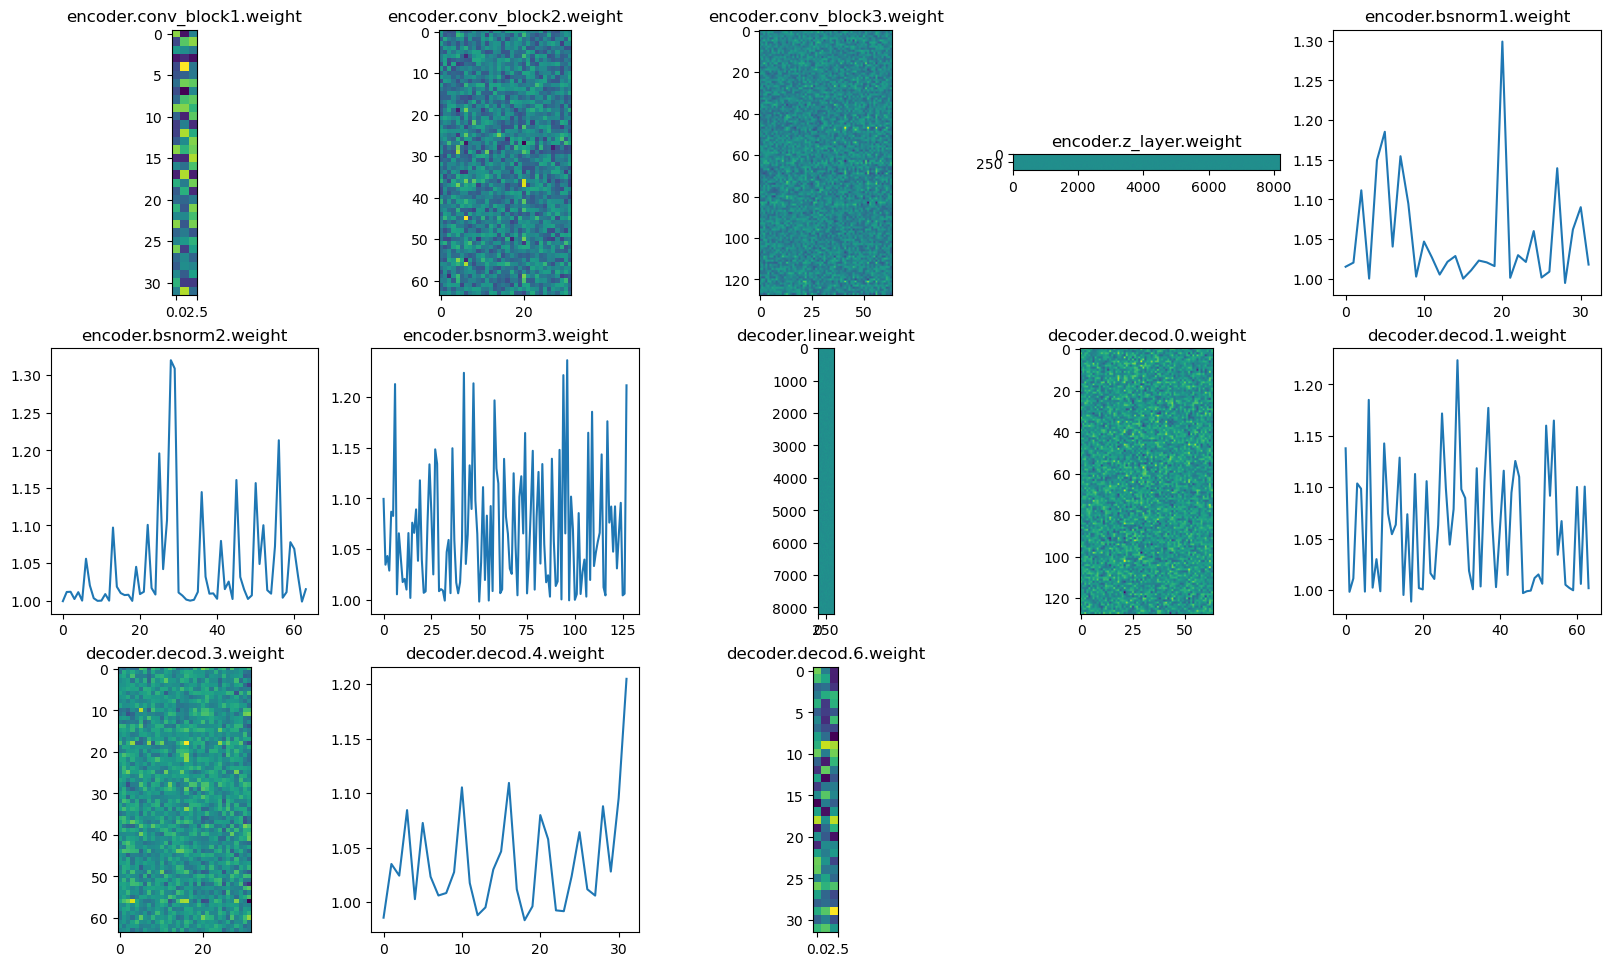

In [51]:
import torch
import matplotlib.pyplot as plt

def visualize_weights(model):
    counter=1
    plt.figure(figsize = (20,20))
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights = param.data.cpu().numpy()
            print(weights.shape)
            
            if len(weights.shape) > 2: 
                plt.subplot(5,5,counter)
                plt.imshow(weights[:, :, 0, 0])
                counter+=1
            if len(weights.shape) == 2: 
                plt.subplot(5,5,counter)
                plt.imshow(weights)
                counter+=1
            if len(weights.shape) < 2: 
                plt.subplot(5,5,counter)
                plt.plot(weights)
                counter+=1
            plt.title(name)
            
                
            # if len(weights.shape) == 2:  # Linear layer weights
            #     plt.figure(figsize=(10, 5))
            #     plt.imshow(weights, cmap='viridis', aspect='auto')
            #     plt.title(name)
            #     plt.colorbar()
            #     plt.xlabel('Input Neurons')
            #     plt.ylabel('Output Neurons')
            #     plt.show()
            # elif len(weights.shape) == 4:  # Convolutional layer weights
            #     num_kernels = weights.shape[0]
            #     num_channels = weights.shape[1]
            #     fig, axs = plt.subplots(num_kernels, num_channels, figsize=(10, 10))
            #     for i in range(num_kernels):
            #         for j in range(num_channels):
            #             axs[i, j].imshow(weights[i, j], cmap='viridis')
            #             axs[i, j].axis('off')
            #             #axs[i, j].set_title(f'Kernel {i+1}, Channel {j+1}')
            #     #plt.suptitle(name)
    plt.show()

# Assuming `model` is your PyTorch model
visualize_weights(exp.model)


In [52]:
from domid.dsets.dset_her3 import DsetHER3
df = pd.read_csv(args.meta_data_csv)
# mask = df[df["subject"] == 0]
# # mask = df['resp'].values == ind_global  # response (0 o 1)
# img_paths = np.array(mask["path"])  # [:400]
ind_global =0
# df = pd.read_csv(df_path)        
mask = df[df["machine_encod"] == ind_global]
# mask = df['resp'].values == ind_global  # response (0 o 1)
img_paths = np.array(mask["img_path"])

trans =  transforms.Compose([transforms.Resize((i_w, i_w)),transforms.ToTensor()]) # [transforms.Resize((self.ImSize.w, self.ImSize.h))]
# dset = DsetHER3(class_num=0, path=img_paths, args=args, transform=trans)
dset = DsetHER3(ind_global, args.dpath, img_paths, args.d_dim, args.inject_var,metadata_path=args.meta_data_csv,  transform=trans)

In [53]:
#exp.execute()

In [54]:
model

ModelAE(
  (encoder): ConvolutionalEncoder(
    (conv_block1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_block2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_block3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (encod): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (z_layer): Linear(in_features=8192, out_features=500, bias=True)
    (bsnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bsnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bsnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): ConvolutionalDecoder(
    (linear): Linear(in_features=500, out_fea

In [55]:
import torch
new_domains = []
z_tot = torch.zeros(len(dset), 500)
counter = 0
# for sub_num in range(0, 65):
    # mask = df[df["subject"] == sub_num]
    # img_paths = np.array(mask["path"])
    # trans = [transforms.Resize((64, 64))]  # [transforms.Resize((self.ImSize.w, self.ImSize.h))]
    # dset = DsetHER3(class_num=0, path=img_paths, args=args, transform=trans)

dset = DsetHER3(ind_global, args.dpath, img_paths, args.d_dim, args.inject_var,metadata_path=args.meta_data_csv,  transform=trans)
batch_img = torch.zeros(len(dset), 3, 64, 64)
ii=0
for image, *_ in dset:
    batch_img[ii, :, :, :] = image
    ii+=1

outputs = model.infer_d_v_2(batch_img, [])
        # if len(np.where(img_locs_ == img_id[3:])[0])>0:
        #     indx = np.where(img_locs_ == img_id[3:])[0][0]
        #     new_domains.append(domain[indx])
        #     enc_h1, enc_h2, enc_h3, z, z = model.encoder(image.unsqueeze(0))
        #     h = self.gnn_model(x, self.adj.to(self.device), enc_h1, enc_h2, enc_h3, z)
        #     probs_c = F.softmax(
        #         h, dim=1
        #     )
        #     z_tot[counter, :] =z
        #     counter+=1


    

In [56]:
outputs[-1].shape



torch.Size([168, 3, 64, 64])

In [57]:
# import torch
# import matplotlib.pyplot as plt

# # Assuming your tensor of images is named 'images_tensor'
# # images_tensor.shape should be (168, 3, 64, 64)

# def plot_images(images_tensor, num_images=10):
#     fig, axes = plt.subplots(2, 5, figsize=(15, 6))
#     for i, ax in enumerate(axes.flatten()):
#         if i < num_images:
#             image = images_tensor[i].permute(1, 2, 0).detach().cpu().numpy() # Permute dimensions and convert to numpy array
#             ax.imshow(image)
#             ax.axis('off')
#     plt.show()

# # Plot 10 images
# plot_images(outputs[-1])


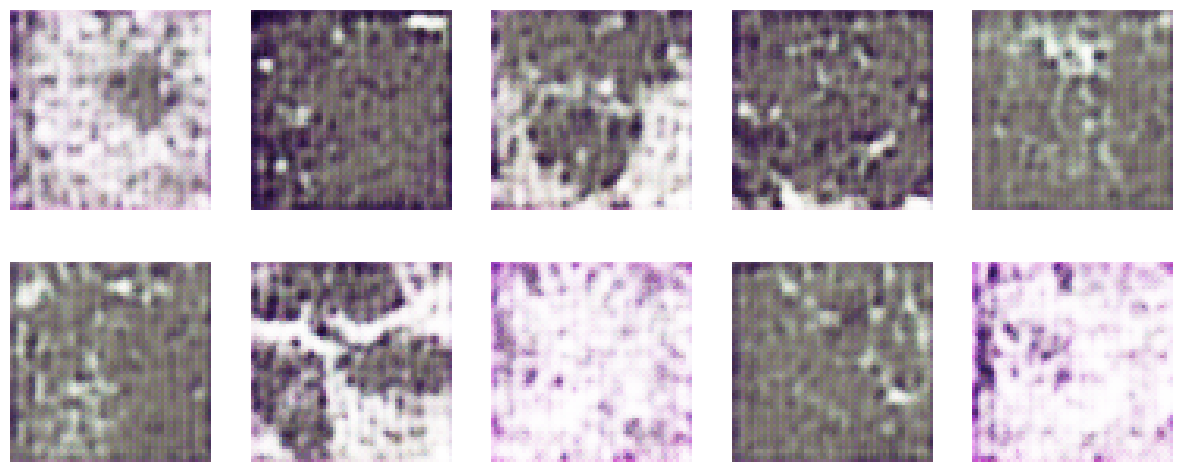

In [58]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Assuming your tensor of images is named 'images_tensor'
# images_tensor.shape should be (168, 3, 64, 64)

def plot_images(images_tensor, num_images=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    to_pil = transforms.ToPILImage()
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            image = to_pil(images_tensor[i])
            ax.imshow(image)
            ax.axis('off')
    plt.show()

# Plot 10 images
plot_images(outputs[-1])


In [59]:
decoded = outputs[-1]

In [60]:
print(torch.min(outputs[-1]),torch.mean(outputs[-1]),torch.max(outputs[-1]))


tensor(6.6432e-08, grad_fn=<MinBackward1>) tensor(0.4803, grad_fn=<MeanBackward0>) tensor(1.0000, grad_fn=<MaxBackward1>)


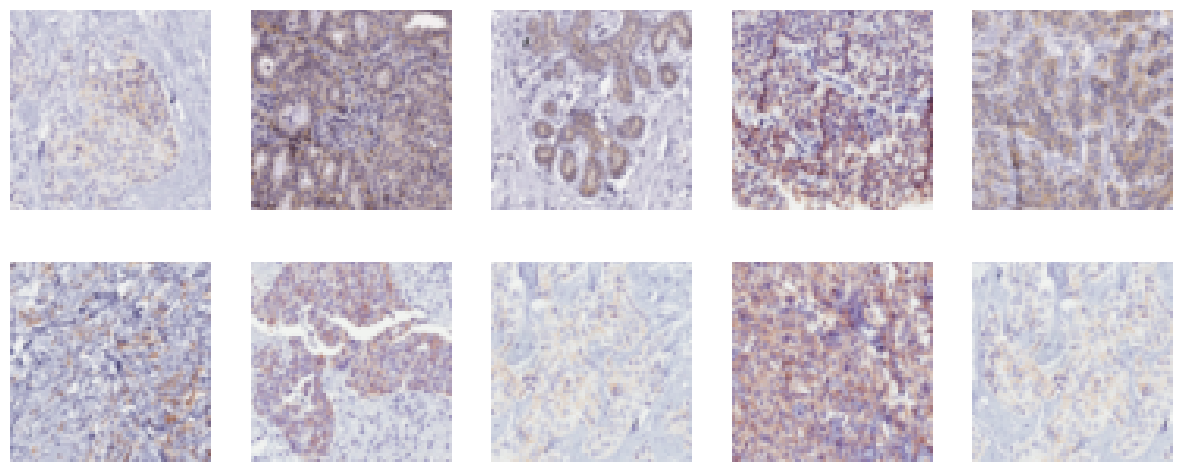

In [61]:
plot_images(batch_img)

In [62]:
exp.execute()


 Experiment start at : 2024-04-02 11:03:00.614123
before training, model accuracy: (0.316, array([[54, 52,  0, 39],
       [33, 42,  0, 37],
       [26, 28,  0, 29],
       [52, 46,  0, 62]]), 0, array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]]))
Epoch 1. Pretraining.
epoch: 1
pooled train clustering acc (vec_d correlation):  0
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
clustering validation acc:  0
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
pooled train clustering acc (vec_y correlation):  0.32
[[ 0 55  3 53]
 [ 0 77 52 34]
 [ 0 28 76  2]
 [ 0  8 37 79]]
now:  2024-04-02 11:04:00.655828 epoch time:  0:01:00.041705 used:  0:01:00.041705
Epoch 2. Pretraining.
############################################################
Epoch 2: Finished pretraining and starting to use the full model loss.
############################################################
epoch: 2
pooled train clustering acc (vec_d correlation):  0
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 

/home/mariia.sidulova/domid_upgraded/DomId/domid/algos/observers/c_obvisitor_clustering.py:107: UserWarning: failed to delete model
  warnings.warn("failed to delete model")


In [63]:
args

Namespace(config_file=None, lr=0.0001, gamma_reg=0.1, es=1, seed=0, nocu=False, device=None, gen=False, keep_model=False, epos=5, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='ae', out='zoutput', dpath='../../HER2/combined_train/', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='ae', acon=None, task='her3', bs=100, split=0.0, te_d=['1', '2', '0'], tr_d=['1', '2', '0'], san_check=False, san_num=8, loglevel='DEBUG', shuffling_off=False, zd_dim=500, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=1, 

In [ ]:

# from domid.compos.exp.exp_main import Exp
# exp = Exp(conf, task, model=model)

In [ ]:
# exp = mk_exp(task='her2', model='vade', 
#              trainer='cluster',
#              train_domain = '0 1 2', 
#              test_domain='0', prior="Gaus", 
#              batchsize = 2, pre_tr=2, epos=20, model_method="cnn")
# Note that by default the experiment, including DL training, will be performed on CPU. To use GPU/CUDA, pass `nocu=False` as an additional argument to mk_exp.

In [ ]:
ex = '2024-03-27_09:50:54.219092_her3_ae/'

In [17]:
domain, vec_d, vec_y, img_locs, model_name, command_line = load_files(ex)

In [18]:
command_line

Namespace(config_file=None, lr=0.0001, gamma_reg=0.1, es=10, seed=0, nocu=False, device=None, gen=False, keep_model=False, epos=100, epo_te=1, debug=False, dmem=False, no_dump=False, trainer=None, out='zoutput', dpath='../../png_files/Training/', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath='domid/algos/builder_AE.py', exptag='exptag', aggtag='aggtag', bm_dir=None, msel=None, aname='ae', acon=None, task='weah', bs=32, split=0, te_d=['0'], tr_d=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], san_check=False, san_num=8, zd_dim=500, zx_dim=0, zy_dim=64, topic_dim=3, topic_h_dim=8, img_h_dim=8, nname_topic_distrib_img2topic=None, npath_topic_distrib_img2topic=None, nname_encoder_sandwich_layer_img2h4zd=None, npath_encoder_sandwich_layer_img2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, warmup=100, tau=0.05, epos_per_match_update=5, epochs_ctr=None, nperm=31, pperm=0.7, jige